In [79]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#### Modelado de la red

In [80]:
class sep_cnn(nn.Module):
    def __init__(self,t1,f1,t2,f2,N1,N2,input_shape=[513,25],NN=128,padding1=(20,0)):
        super(sep_cnn, self).__init__()
        
        # --------- ENCODING ---------- #
        self.vconv = nn.Conv2d(1,N1, kernel_size=(f1,t1),padding=padding1)
        self.hconv = nn.Conv2d(N1,N2, kernel_size=(f2,t2),padding='valid')
        
        #cuello de botella
        self.flat = nn.Flatten()
        self.ffc = nn.Sequential(
            nn.Linear(N2*(input_shape[0]-f1-f2+2+padding1[0]*2)*(input_shape[1]-t1-t2+2), NN),
            nn.ReLU())
        
        # --------- DECODING ---------- #
        self.sfc1 = nn.Sequential(
            nn.Linear(NN,N2*(input_shape[0]-f1-f2+2+padding1[0]*2)*(input_shape[1]-t1-t2+2)),
            nn.ReLU())
        self.sfc2 = nn.Sequential(
            nn.Linear(NN,N2*(input_shape[0]-f1-f2+2+padding1[0]*2)*(input_shape[1]-t1-t2+2)),
            nn.ReLU())
        
        self.hdeconv1 = nn.ConvTranspose2d(N2, N1, kernel_size=(f2,t2))
        self.hdeconv2 = nn.ConvTranspose2d(N2, N1, kernel_size=(f2,t2))
        
        self.vdeconv1 = nn.ConvTranspose2d(N1, 1, kernel_size=(f1-padding1[0]*2,t1))
        self.vdeconv2 = nn.ConvTranspose2d(N1, 1, kernel_size=(f1-padding1[0]*2,t1))
        # Tengo 2 para 2 fuentes: 'drums', 'bass'

    def forward(self, x):
        
        # --------- ENCODING ---------- #
        x = self.vconv(x)
        x = self.hconv(x)

        #Fully Connected 
        shlh = x.shape
        x = self.flat(x)
        x = self.ffc(x)
        
        # --------- DECODING ---------- #
        x1 = self.sfc1(x)
        x2 = self.sfc2(x)
        
        x1 = x1.view(shlh[0], shlh[1],shlh[2],shlh[3])
        x2 = x2.view(shlh[0], shlh[1],shlh[2],shlh[3])

        x1 = self.hdeconv1(x1)
        x2 = self.hdeconv2(x2)

        x1 = self.vdeconv1(x1)
        x2 = self.vdeconv2(x2)

        return x1, x2

#### Carga de datos
Para cada canción, obtenemos 30 segundos de cada una. Sacamos la STFT de cada una y hacemos segmentos de 25 time frames.

In [81]:
def load_audio(file_path, bool_phase=False):
    audio,sr = librosa.load(file_path,duration=30,sr=22050,mono=False)
    
    stft_bateria = librosa.stft(audio[1,:], n_fft=1024, hop_length=256)
    stft_bajo = librosa.stft(audio[3,:], n_fft=1024, hop_length=256)
    mix = audio[3,:] + audio[1,:]
    stft_mix = librosa.stft(mix, n_fft=1024, hop_length=256)
    
    segment_size = 25
    n_frames = stft_mix.shape[1]
    n_segments = n_frames // segment_size*segment_size
    
    mix = [torch.tensor(np.abs(stft_mix[:, i:i+segment_size])) for i in range(0,n_segments,segment_size)]
    bateria = [torch.tensor(np.abs(stft_bateria[:, i:i+segment_size])) for i in range(0,n_segments,segment_size)]
    bajo = [torch.tensor(np.abs(stft_bajo[:, i:i+segment_size])) for i in range(0,n_segments,segment_size)]

    if(bool_phase):                     # si necesito la fase (reconstrucción)
        fase = [np.angle(stft_mix[:, i:i+segment_size]) for i in range(0,n_segments,segment_size)]
        return mix,bateria,bajo,fase    

    return mix,bateria,bajo             # si no necesito la fase (entrenamiento)

class AudioDataset(Dataset):
    def __init__(self, mix_segments, bajo_segments, bateria_segments):
        self.mix_segments = mix_segments
        self.bajo_segments = bajo_segments
        self.bateria_segments = bateria_segments

    def __len__(self):
        return len(self.mix_segments)

    def __getitem__(self, idx):
        mix = self.mix_segments[idx]
        bajo = self.bajo_segments[idx]
        bateria = self.bateria_segments[idx]
        return mix, bajo, bateria

In [82]:
mix,bateria,bajo = load_audio('song1.wav')
print(len(mix),len(bateria),len(bajo))
print(np.shape(mix[0]),np.shape(bateria[0]),np.shape(bajo[0]))

103 103 103
torch.Size([513, 25]) torch.Size([513, 25]) torch.Size([513, 25])


#### Entrenamiento

Parámetros del modelo:

In [83]:
inp_size = [513,25]
t1=1
f1=513
t2=25
f2=1
N1=50
N2=30
NN=128
alpha = 0.005
batch_size = 25
n_epochs = 10

Función de pérdida para aprendizaje

In [84]:
class sq_error(nn.Module):
    def __init__(self,weight=None,size_average=True):
        super(sq_error,self).__init__()
    def forward(self,pred_bajo,pred_bateria,orig_bajo,orig_bateria):
        L_sq = torch.sum((pred_bajo-orig_bajo).pow(2)) + torch.sum((pred_bateria - orig_bateria).pow(2))
        L_diff = torch.sum((pred_bajo - pred_bateria).pow(2))
        return (L_sq - alpha*L_diff)
        # en el paper hay más partes para la función de pérdida pero porque saca 4 fuentes en vez de 2

Inicializamos el modelo, los métodos necesarios y la base de datos para el entrenamiento.

In [85]:
model = sep_cnn(t1,f1,t2,f2,N1,N2,inp_size,NN)
criterion = sq_error()
optimizer = optim.Adam(model.parameters(),lr=0.01)

train_path = './musdbwav/train'
mix_seg, bajo_seg, bateria_seg = [], [], []
for root,dirs,files in os.walk(train_path):
    for file in files:
        if file.endswith(".wav"):
            path_cancion = os.path.join(root,file)
            mix, bajo, bateria = load_audio(path_cancion)
            mix_seg.extend(mix)
            bajo_seg.extend(bajo)
            bateria_seg.extend(bateria)

train_data = AudioDataset(mix_seg,bajo_seg,bateria_seg)
train_loader = DataLoader(dataset=train_data,batch_size=1,shuffle=True)

Time-Frequency Masking

In [86]:
def TimeFreqMasking(bajo,bateria):
    suma = torch.abs(bajo) + torch.abs(bateria)
    bajo = torch.abs(bajo)/suma
    bateria = torch.abs(bateria)/suma

    return bajo,bateria

Entrenamos con lo seteado anteriormente, determinando el número de épocas:

In [87]:
for epoch in range(n_epochs):
    ini = time.time()
    total_loss = 0.0
    total_batches = 0
    
    for orig_mix, orig_bateria, orig_bajo in train_loader:
        optimizer.zero_grad()

        orig_mix = orig_mix.unsqueeze(dim=0)
        o_bateria, o_bajo = model(orig_mix)
        mask_bajo, mask_bateria = TimeFreqMasking(o_bateria, o_bajo)

        pred_bajo = orig_mix * mask_bajo
        pred_bateria = orig_mix * mask_bateria

        loss = criterion(pred_bajo, pred_bateria, orig_bajo, orig_bateria)
        total_loss += loss.item()
        total_batches += 1
        
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / total_batches
    fin = time.time()
    print(f'Epoch [{epoch+1}/{n_epochs}], Average Loss: {avg_loss}, Duration: {round(fin-ini,2)} seg.')
    
    if avg_loss < 0.1:
        print(f'Loss alcanzó el umbral. Entrenamiento finalizado.')
        break


Epoch [1/10], Average Loss: 4941.1754253122635, Duration: 245.65 seg.
Epoch [2/10], Average Loss: 3830.5554754984505, Duration: 266.99 seg.
Epoch [3/10], Average Loss: 3348.6444672297484, Duration: 255.79 seg.
Epoch [4/10], Average Loss: 3085.239393480744, Duration: 267.4 seg.
Epoch [5/10], Average Loss: 2999.981482520787, Duration: 273.11 seg.
Epoch [6/10], Average Loss: 2664.5320916173364, Duration: 273.65 seg.
Epoch [7/10], Average Loss: 2455.8345932990774, Duration: 272.36 seg.
Epoch [8/10], Average Loss: 2297.6815828371487, Duration: 268.74 seg.
Epoch [9/10], Average Loss: 2149.3593160451774, Duration: 280.16 seg.
Epoch [10/10], Average Loss: 2023.5741241851608, Duration: 294.18 seg.


#### Testing

In [88]:
from scipy.io.wavfile import write

In [89]:
audio_path = 'song1.wav'
audio,sr = librosa.load(audio_path,sr=22050,duration=30,mono=False)
audio = audio[1,:] + audio[3,:]
spectrogram = librosa.stft(audio,n_fft=1024,hop_length=256)
magnitude_spectrogram = np.abs(spectrogram)
fase_spectrogram = np.angle(spectrogram)

# Declaración de las matrices de espectogramas vacías
tot_spec_inst1 = torch.empty(513, 0)
tot_spec_inst2 = torch.empty(513, 0)  

# Bucle que recorre todo el espectograma con saltos de 25 y superposicón 2
i = 0
while (i + 25 < magnitude_spectrogram.shape[1]):
    
    # Corte del espectograma a 25 frames
    limit = i + 25
    act_spectogram = torch.from_numpy(magnitude_spectrogram[:, i:limit]).unsqueeze(0).unsqueeze(0)
    
    # Llamada al modelo convolucional
    act_spec_inst1, act_spec_inst2 = model(act_spectogram)
    # Se consideran las dimensiones de interes
    
    #print(act_spec_inst1.shape)
    mask_bajo, mask_bateria = TimeFreqMasking(act_spec_inst1,act_spec_inst2)
    
    act_spec_inst1 = act_spectogram*mask_bajo
    act_spec_inst2 = act_spectogram*mask_bateria
    act_spec_inst1 = act_spec_inst1[0][0]
    act_spec_inst2 = act_spec_inst2[0][0]
    # Convertir espectogramas a NumPy
    act_spec_inst1_np = act_spec_inst1.detach().numpy()
    act_spec_inst2_np = act_spec_inst2.detach().numpy()

    if i != 0:
        # Actualizo las columnas superpuestas con el promedio
        tot_spec_inst1[:, -2] = (tot_spec_inst1[:, -2] + act_spec_inst1[:,0]) / 2
        tot_spec_inst1[:, -1] = (tot_spec_inst1[:, -1] + act_spec_inst1[:,1]) / 2
        tot_spec_inst2[:, -2] = (tot_spec_inst2[:, -2] + act_spec_inst2[:,0]) / 2
        tot_spec_inst2[:, -1] = (tot_spec_inst2[:, -1] + act_spec_inst2[:,1]) / 2
    
    # Concatenar tensores de PyTorch
    tot_spec_inst1 = torch.cat((tot_spec_inst1, torch.from_numpy(act_spec_inst1_np[:, 2:])), dim=1)
    tot_spec_inst2 = torch.cat((tot_spec_inst2, torch.from_numpy(act_spec_inst2_np[:, 2:])), dim=1)
    
    i += 23

bateria = tot_spec_inst2.detach().numpy()*fase_spectrogram[:,0:2576]
reconstructed_audio_inst2 = librosa.istft(bateria, win_length=1024, hop_length=256, window='hann', center='true')

bajo = tot_spec_inst1.detach().numpy()*fase_spectrogram[:,0:2576]
reconstructed_audio_inst1 = librosa.istft(bajo, win_length=1024, hop_length=256, window='hann', center='true')

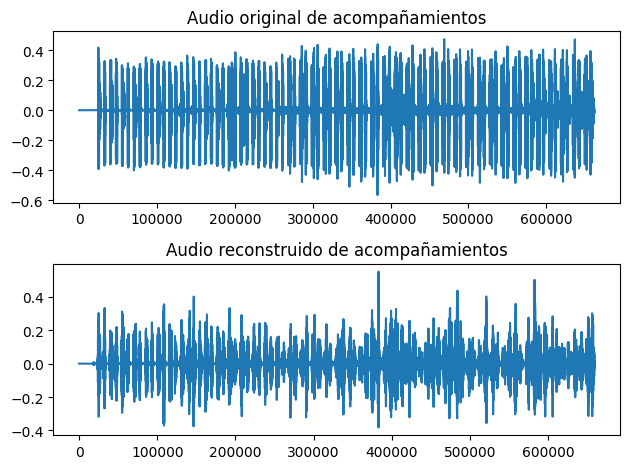

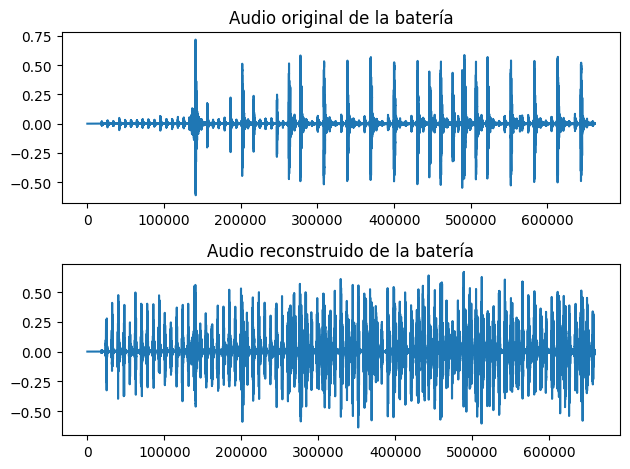

In [90]:
sf.write("resultados_inst2.wav", reconstructed_audio_inst2, 22050)
sf.write("resultados_inst1.wav", reconstructed_audio_inst1, 22050)

audio_path = 'song1.wav'
audio,sr = librosa.load('song1.wav',duration=30,sr=22050,mono=False)

fig, axs = plt.subplots(2)
vocals = audio[3,:]
axs[0].plot(vocals)
axs[0].title.set_text('Audio original de acompañamientos')
axs[1].plot(reconstructed_audio_inst1)
axs[1].title.set_text('Audio reconstruido de acompañamientos')
plt.tight_layout()
plt.show()

fig,axs = plt.subplots(2)
bateria = audio[1,:]
axs[1].plot(reconstructed_audio_inst2)
axs[1].title.set_text('Audio reconstruido de la batería')
axs[0].plot(bateria)
axs[0].title.set_text('Audio original de la batería')
plt.tight_layout()
sf.write("bajo_orig.wav", vocals, sr)
sf.write("bateria_orig.wav", bateria, sr)